In [3]:
import csv
import math
import time
import os.path
import datetime
import collections
import pandas as pd
import numpy as np
import scipy as sci
from sklearn import svm
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Training and Implementation

In [4]:
def get_data_vector_numpy(student_id, exam_id, feature_list=None):
    processed_input_file = f"E:\Research\Capstone-smartwatch stress detector\processed_datatset\merged{student_id}{exam_id}.csv"
    df = pd.read_csv(processed_input_file)
    if feature_list is None:
        feature_list = ['HRV', 'EDA', 'TEMP']
    
    feature_super_vector = []
    for feature in feature_list:     
        feature_col = df[feature].tolist() 
        feature_col_norm =stats.zscore(feature_col)
        #feature_vec = [np.max(feature_col), np.min(feature_col), np.mean(feature_col), np.median(feature_col), np.std(feature_col)]
        feature_vec = [np.max(feature_col_norm),np.average(feature_col_norm), np.min(feature_col_norm), np.mean(feature_col_norm), np.median(feature_col_norm), np.std(feature_col_norm),np.var(feature_col_norm)]
        feature_super_vector += feature_vec
    #print(feature_super_vector)
    #print(feature_col)
    return np.asarray(feature_super_vector)

In [5]:
df = pd.read_csv("E:\Research\Capstone-smartwatch stress detector\processed_datatset\mergedS2Final.csv")
a = df['HRV'].tolist()
feature_col_nor =stats.zscore(a)
feature_col_nor

array([-0.17971713, -1.72270312, -1.16216164, ...,  0.97637088,
        0.87043453,  0.76541936])

In [80]:
df.info

<bound method DataFrame.info of           ID            Timestamp      Hour     HRV       EDA         BVP  \
0      Final  2018-12-05 18:29:14  18:29:14  116.00  0.019860    0.160937   
1      Final  2018-12-05 18:29:15  18:29:15   82.50  0.018900   -7.858906   
2      Final  2018-12-05 18:29:16  18:29:16   94.67  0.019540   13.248594   
3      Final  2018-12-05 18:29:17  18:29:17   91.50  0.019220  -98.349375   
4      Final  2018-12-05 18:29:18  18:29:18   88.20  0.019860  115.572031   
...      ...                  ...       ...     ...       ...         ...   
25322  Final  2018-12-06 01:31:16  01:31:16  145.78  0.014735    2.781406   
25323  Final  2018-12-06 01:31:17  01:31:17  143.43  0.016016   23.250313   
25324  Final  2018-12-06 01:31:18  01:31:18  141.10  0.016337  -27.202500   
25325  Final  2018-12-06 01:31:19  01:31:19  138.80  0.015376   -3.726719   
25326  Final  2018-12-06 01:31:20  01:31:20  136.52  0.016016    0.735600   

        TEMP         ACC_X     ACC_Y     AC

In [81]:
df.describe()

,HRV,EDA,BVP,TEMP,ACC_X,ACC_Y,ACC_Z,ACC_Overall,SumIBI,Beats
count,25327.000000,25327.000000,25327.000000,25327.000000,25327.000000,2.532700e+04,2.532700e+04,2.532700e+04,25327.000000,25327.000000
mean,119.901866,0.078319,0.000329,28.184036,0.000005,4.623243e-06,4.596850e-07,3.022923e-02,0.206191,0.364433
std,21.711578,0.095918,22.730315,6.145280,0.011175,1.108168e-02,1.582643e-02,6.771483e-02,0.426818,0.755989
min,69.800000,0.008329,-338.954844,17.990000,-0.245143,-2.120153e-01,-2.236816e-01,2.220717e-16,0.000000,0.000000
25%,105.380000,0.015056,-0.717344,23.010000,-0.000207,-1.937834e-04,-3.234017e-04,2.743570e-03,0.000000,0.000000
50%,114.950000,0.016337,0.000156,23.770000,0.000000,6.938894e-18,-5.551115e-17,7.891698e-03,0.000000,0.000000
75%,134.380000,0.122634,0.619453,35.650000,0.000218,1.613641e-04,3.234712e-04,1.477765e-02,0.000000,0.000000
max,201.670000,0.718453,320.470156,36.070000,0.210980,2.151978e-01,2.289399e-01,9.861466e-01,1.703203,3.000000


In [6]:
df.corr()

,HRV,EDA,BVP,TEMP,ACC_X,ACC_Y,ACC_Z,ACC_Overall,SumIBI,Beats
HRV,1.000000,-0.462424,-0.000033,-0.559266,0.001268,0.000700,0.000166,-0.272211,-0.327942,-0.324322
EDA,-0.462424,1.000000,-0.000538,0.656389,-0.001059,0.000806,-0.000279,0.344416,0.294274,0.288557
BVP,-0.000033,-0.000538,1.000000,-0.000201,-0.029866,0.026260,-0.001246,-0.008155,0.004934,0.007390
TEMP,-0.559266,0.656389,-0.000201,1.000000,-0.000400,0.000469,-0.000006,0.151320,0.500626,0.493511
ACC_X,0.001268,-0.001059,-0.029866,-0.000400,1.000000,-0.214889,0.230334,0.007008,0.006181,0.006488
ACC_Y,0.000700,0.000806,0.026260,0.000469,-0.214889,1.000000,0.255962,0.022301,0.000702,0.000467
ACC_Z,0.000166,-0.000279,-0.001246,-0.000006,0.230334,0.255962,1.000000,-0.018008,0.005104,0.005444
ACC_Overall,-0.272211,0.344416,-0.008155,0.151320,0.007008,0.022301,-0.018008,1.000000,-0.068750,-0.062185
SumIBI,-0.327942,0.294274,0.004934,0.500626,0.006181,0.000702,0.005104,-0.068750,1.000000,0.995071
Beats,-0.324322,0.288557,0.007390,0.493511,0.006488,0.000467,0.005444,-0.062185,0.995071,1.000000


In [79]:
get_data_vector_numpy('S1', 'Final',feature_list= ['EDA', 'BVP', 'TEMP', 'ACC_X','ACC_Y'])

array([ 2.41982734e+00,  1.16666700e-16, -1.23524626e+00,  1.16666700e-16,
       -9.08557972e-01,  1.00000000e+00,  1.00000000e+00,  2.40306435e+01,
       -5.44501565e-18, -1.89032165e+01, -5.44501565e-18,  2.39771730e-05,
        1.00000000e+00,  1.00000000e+00,  1.30508991e+00,  0.00000000e+00,
       -2.33709432e+00,  0.00000000e+00, -5.39382846e-01,  1.00000000e+00,
        1.00000000e+00,  1.19963538e+01,  4.13954110e-18, -1.29222230e+01,
        4.13954110e-18,  4.66193632e-05,  1.00000000e+00,  1.00000000e+00,
        1.80160505e+01,  3.26605995e-18, -1.38793085e+01,  3.26605995e-18,
        1.20623813e-04,  1.00000000e+00,  1.00000000e+00])

#remove df beyond exam timeframe - ignore
def normalize(values):
    return (values - values.min())/(values.max() - values.min())

def remove_exam_end(student_id, exam_id):
    processed_input_file = f"E:\Research\Capstone-smartwatch stress detector\processed_datatset\merged{student_id}{exam_id}.csv"
    df = pd.read_csv(processed_input_file)
    if exam_id == 'Final':
        exend = df[ (df['Hour'] >= '22:10:00')].index
        df.drop(exend, inplace=True)
        #print(df.shape)
        #plt.plot(df["EDA"])                     
        #plt.show() 
    if exam_id == 'Midterm 1':
        exend = df[ (df['Hour'] >= '17:40:00')].index
        df.drop(exend, inplace=True)
    if exam_id == 'Midterm 2':
        exend = df[ (df['Hour'] >= '18:40:00')].index
        df.drop(exend, inplace=True)
     

# Training Classiffiers 

In [51]:
def get_training_and_test_data(feature_list=None, threshold=89):
    student_ids = [f"S{x}" for x in range(1, 11)]
    exam_ids = ['Midterm 1', 'Midterm 2', 'Final']
    data_y_all = pd.read_csv(r'E:\Research\Capstone-smartwatch stress detector\Dataset\ds\a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0\StudentGrades.csv')
    list_data_x = []
    list_data_y = []
    for student_id in student_ids:
        for exam_id in exam_ids:
            #remove_exam_end(student_id, exam_id)
            #print(f'{student_id} {exam_id}')
            #'HRV', 'EDA', 'BVP', 'TEMP', 'ACC_X','ACC_Y', 'ACC_Z', 'ACC_Overall', 'SumIBI', 'Beats'
            # 1 - 'HRV','EDA','ACC_X','ACC_Y', 'ACC_Z'
            data_i = get_data_vector_numpy(student_id, exam_id, feature_list=['HRV','EDA','ACC_X','ACC_Y', 'ACC_Z'])
            list_data_x.append(data_i)
            y_val = 1 if data_y_all.loc[(data_y_all['student_id'] == student_id) & (data_y_all['exam_id'] == exam_id)]['marks'].values[0] > threshold else 0 
            list_data_y.append(y_val)
    return np.asarray(list_data_x), np.asarray(list_data_y)
#print(X.shape)
#print(y.shape)

In [52]:
X, y = get_training_and_test_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [53]:
X.shape

(30, 35)

In [54]:
y.shape

(30,)

In [55]:
y_train,y_test

(array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0]),
 array([0, 0, 1]))

In [56]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27, 35), (3, 35), (27,), (3,))

# Results and ROC

In [57]:
# deep learning
from sklearn.linear_model import Perceptron
per_clf = Perceptron(eta0=1.0,max_iter=1000,tol=1e-3, random_state=0)
per_scores = cross_val_score(per_clf, X, y, cv=10)
per_clf.fit(X_train, y_train)
Perceptron()

from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
mlp_clf.fit(X_train, y_train)
mlp_scores = cross_val_score(mlp_clf, X, y, cv=12)#9
#mlp_clf.score(X, y)

In [58]:
per_scores.mean(), mlp_scores.mean()

(0.8333333333333333, 0.861111111111111)

In [59]:
# Run different experiments by importing classifiers and running different trainings
svm_clf = svm.SVC(kernel='linear', C=1, random_state=42,probability=True)
svm_clf.fit(X_train, y_train)
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)#6-1

#knn
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
knn_clf.score(X_test, y_test)
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=10)

#lR - acc .86,roc-.9,#2,15, marks-89
reg = LogisticRegression()
reg.fit(X_train, y_train)
reg_scores = cross_val_score(reg, X_train, y_train, cv=9) #15,5,9(1)

#DT
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
dtc_scores = cross_val_score(dtc, X_train, y_train, cv=5)

#gnb
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_scores = cross_val_score(gnb, X_train, y_train, cv=5)

#rf
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_scores = cross_val_score(rfc, X_train, y_train, cv=5)

import warnings
warnings.filterwarnings('ignore')

In [60]:
# svm_clf, knn_clf, reg, dtc
svm_scores.mean(), reg_scores.mean(), gnb_scores.mean(), rfc_scores.mean(), knn_scores.mean()

(0.8,
 0.8888888888888888,
 0.8133333333333332,
 0.8133333333333332,
 0.8333333333333333)

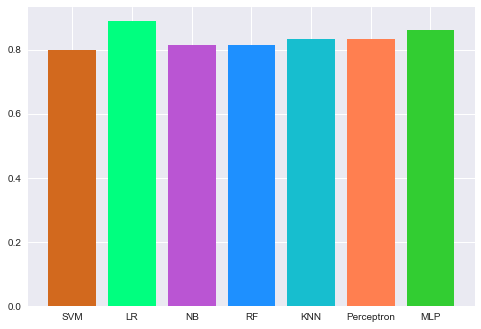

In [103]:
acc = [svm_scores.mean(), reg_scores.mean(), gnb_scores.mean(), rfc_scores.mean(), knn_scores.mean(), per_scores.mean(), mlp_scores.mean()]
bars = ('SVM', 'LR', 'NB', 'RF', 'KNN', 'Perceptron', 'MLP')
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, acc, color=['chocolate', 'springgreen', 'mediumorchid', 'dodgerblue', 'tab:cyan','coral','limegreen'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

# Show graph
plt.show()

In [82]:
pred_prob1 = svm_clf.predict_proba(X_test)
pred_prob2 = reg.predict_proba(X_test)
pred_prob3 = per_clf._predict_proba_lr(X_test)
pred_prob4 = mlp_clf.predict_proba(X_test)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])
auc_score4 = roc_auc_score(y_test, pred_prob4[:,1])

print(auc_score1, auc_score2, auc_score3, auc_score4)

1.0 1.0 0.5 1.0


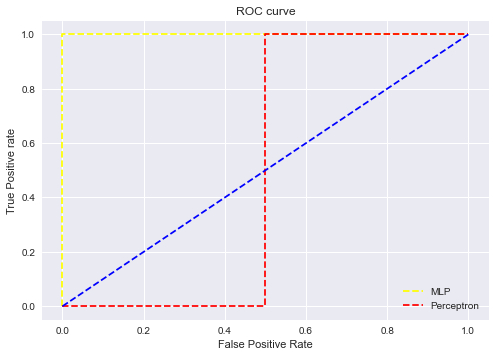

In [77]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr4, tpr4, linestyle='--',color='yellow', label='MLP')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='Perceptron')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

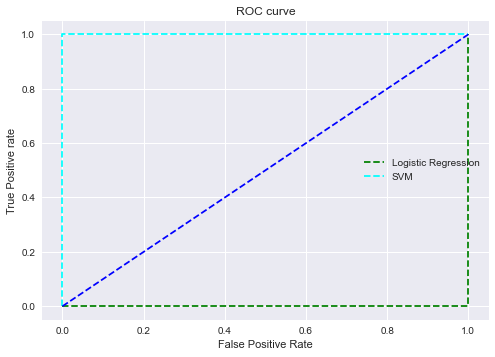

In [78]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Logistic Regression')
plt.plot(fpr1, tpr1, linestyle='--',color='cyan', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [707]:
# One-time code to process labels raw txt to labels csv: can delete
def process_labels_txt_save_csv():
    file_path_y_raw = os.path.join(r'E:\Research\Capstone-smartwatch stress detector\Dataset\ds\a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0', r'StudentGrades.txt')
    exam_ids = ['Midterm 1', 'Midterm 2', 'Final']
    eid = -1
    student_count = 0
    dataframe_headers = ['student_id', 'exam_id', 'marks']
    table_li = []
    with open(file_path_y_raw, 'r') as fraw:
        for line in fraw:
            #print(line.strip())
            if line.startswith('S'):
                student_id, marks_str = line.split('–')
                student_id = 'S' + str(int(student_id.strip()[1:]))
                marks = int(marks_str.strip())
                #print(f'{student_id}: {marks}')
                if student_count % 10 == 0:
                    eid += 1
                student_count += 1
                if eid == 2:
                    marks = int(marks/2) # can remove int and process as all floats
                li = [student_id, exam_ids[eid], marks]
                table_li.append(li)
                print(li)
    labels_df = pd.DataFrame(table_li, columns=dataframe_headers)
    labels_df.to_csv(r'E:\Research\Capstone-smartwatch stress detector\Dataset\ds\a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0\StudentGrades.csv',index=False)

In [480]:
#process_labels_txt_save_csv()